Text(0.5, 1.0, 'Blood Vessel Mask')

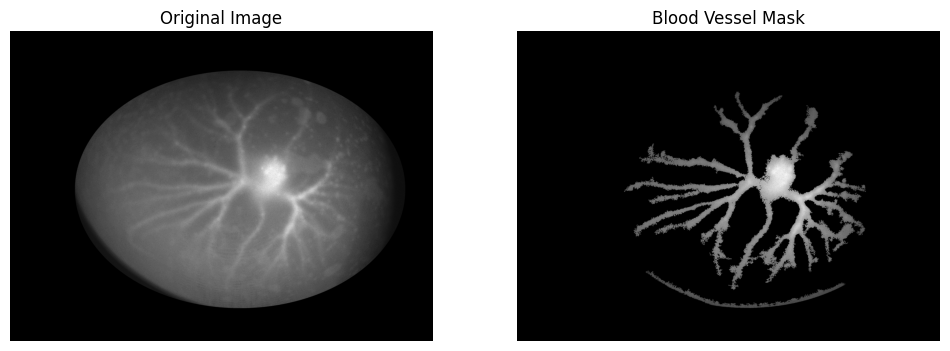

In [ ]:
import cv2
import numpy as np
from skimage import morphology, measure, filters
from skimage.filters import unsharp_mask
from medpy.filter.smoothing import anisotropic_diffusion
import matplotlib.pyplot as plt

base_image = cv2.imread("data/HH25/img_1.png", cv2.IMREAD_GRAYSCALE)
boundary_mask = np.where(base_image != 0, 1, 0).astype(np.uint8)

def feature_extraction(image):
    # Enhance Contrast
    enhanced_image = anisotropic_diffusion(image, niter=20, kappa=100)
    enhanced_image = enhanced_image.astype(np.uint8)
    enhanced_image = unsharp_mask(enhanced_image, radius=50, amount=3)
    enhanced_image = (enhanced_image * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(enhanced_image)
    threshold = np.percentile(enhanced_image.flatten(), 90)
    enhanced_image[enhanced_image < threshold] = 0

    # Threshold Image
    thresh_val = filters.threshold_li(enhanced_image)
    binary_mask = enhanced_image > thresh_val
    binary_mask = binary_mask.astype(np.uint8) * 255

    # Filter Small Particles
    labeled_mask = measure.label(binary_mask)
    clean_mask = morphology.remove_small_objects(labeled_mask, min_size=20000)
    clean_mask = (clean_mask > 0).astype(np.uint8) * 255

    image[clean_mask < 1] = 0
    return image

def enhance_contrast(image):
    image = anisotropic_diffusion(image, niter=20, kappa=100)
    image = image.astype(np.uint8)
    image = unsharp_mask(image, radius=50, amount=3)
    image = (image * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    return image

def threshold_image(image):
    thresh_val = filters.threshold_li(image)
    binary_mask = image > thresh_val
    return binary_mask.astype(np.uint8) * 255

def filter_small_particles(binary_image, min_size=500):
    labeled_image = measure.label(binary_image)
    clean_image = morphology.remove_small_objects(labeled_image, min_size=min_size)
    return (clean_image > 0).astype(np.uint8) * 255

def apply_boundary_mask(binary_image, boundary_mask):
    shrinkage_mask = cv2.resize(boundary_mask, (int(boundary_mask.shape[1] * 0.75), int(boundary_mask.shape[0] * 0.75)))
    filtered_image = cv2.bitwise_and(binary_image, binary_image, mask=shrinkage_mask)
    return filtered_image

fig, axes = plt.subplots(1, 2, figsize=(12, 12))
axes = axes.flatten()
axes[0].imshow(base_image, cmap="gray")
axes[0].axis('off')
axes[0].set_title("Original Image")

new_image = feature_extraction(base_image)

axes[1].imshow(new_image, cmap="gray")
axes[1].axis('off')
axes[1].set_title("Blood Vessel Mask")